In [302]:
import os
import sys

import pandas as pd
import numpy as np
import pstats

import matplotlib.pyplot as plt
import seaborn as sns

In [375]:
def prof_to_df(prof_file):
    p = pstats.Stats(prof_file)
    p.strip_dirs().sort_stats('cumulative')
    stats = p.stats
    
    rows = []
    for func, (cc, nc, tt, ct, callers) in stats.items():
        file, line, name = func
        rows.append({
            'file': file,
            'line': line,
            'name': name,
            'cc': cc,
            'nc': nc,
            'tt': tt,
            'ct': ct,
            'callers': callers
        })
    
    df = pd.DataFrame(rows)
    return df

In [469]:
profiles = []
run_dirs = ['./1/', './2/', './3/', './4/', './5/']

for run_dir in run_dirs:
    for file_name in os.listdir(run_dir):
        if file_name.endswith('.prof'):
            parts = file_name.split('_')
            impl = parts[0]
            move = parts[1]
            run = run_dir.split('/')[1][-1]
            
            df = prof_to_df(os.path.join(run_dir, file_name))
            df['implementation'] = impl
            df['move'] = move
            df['run'] = run
            
            profiles.append(df)

df = pd.concat(profiles, ignore_index=True)

In [472]:
# Create a DataFrame with method names and boolean columns for each implementation
unique_methods_df = df.pivot_table(index='name', columns='implementation', aggfunc='size', fill_value=0).astype(bool).reset_index()
unique_methods_df.columns = ['name', 'CPython', 'PyPy']

# Filter to get method names that don't exist in both implementations
filtered_methods = unique_methods_df[~(unique_methods_df['CPython'] & unique_methods_df['PyPy'])].reset_index(drop=True)

In [473]:
def normalize_func_name(func_name):
    mapping = {
        '<built-in method builtins.len>': '<built-in function len>',
        '<built-in method builtins.abs>': '<built-in function abs>',
        '<built-in method builtins.chr>': '<built-in function chr>',
        '<built-in method builtins.divmod>': '<built-in function divmod>',
        '<built-in method builtins.max>': '<built-in function max>',
        '<built-in method builtins.min>': '<built-in function min>',
        '<built-in method builtins.ord>': '<built-in function ord>',
        '<built-in method __new__ of type object at 0xa43b40>': '<method \'__new__\' of \'type\' objects>'
    }
    return mapping.get(func_name, func_name)

In [474]:
# Apply the normalization function to the 'name' column
df['name'] = df['name'].apply(normalize_func_name)

In [475]:
# Drop unmatched methods
unmatched_methods = [
    # PyPy exclusive
    'encode', 
    'cb', 
    '<listcomp>', 
    '<built-in function _imp.release_lock>', 
    '<built-in function _imp.acquire_lock>', 
    '<built-in function _codecs.utf_8_encode>',
    # CPython exclusive
    '<built-in method builtins.sorted>',
    '<built-in method builtins.print>',
    '<built-in method builtins.bin>'
]

df_filtered = df[~df['name'].isin(unmatched_methods)].reset_index(drop=True)

In [476]:
# Average over 5 runs
df_avg = df_filtered.groupby(['file', 'name', 'implementation', 'move']).agg({
    'cc': 'mean', # num primitive calls
    'nc': 'mean', # num total calls
    'tt': 'mean', # total execution time
    'ct': 'mean' # cumulative execution time
}).reset_index()

# Sum across all moves
df_sum = df_avg.groupby(['name', 'implementation']).agg({
    'cc': 'sum',
    'nc': 'sum',
    'tt': 'sum',
    'ct': 'sum'
}).reset_index()

In [477]:
# Pivot the DataFrame to have separate columns for each implementation
df_pivot = df_sum.pivot_table(index=['name'], columns='implementation', values=['cc', 'nc', 'tt', 'ct']).reset_index()

# Flatten the MultiIndex columns
df_pivot.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in df_pivot.columns.values]

In [436]:
# Create the per_call field
df_pivot['pc_CPython'] = df_pivot['tt_CPython'] / df_pivot['nc_CPython']
df_pivot['pc_PyPy'] = df_pivot['tt_PyPy'] / df_pivot['nc_PyPy']

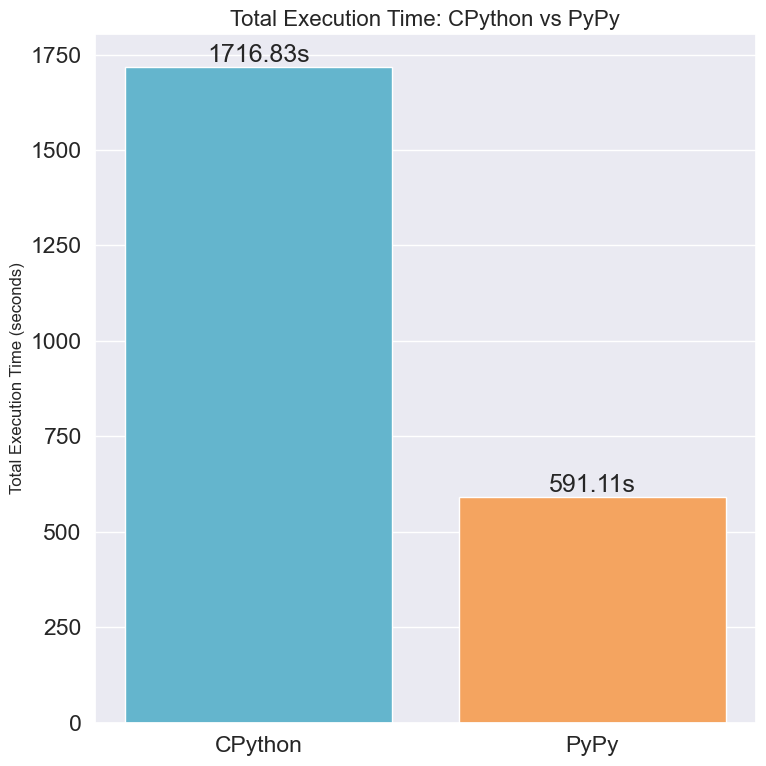

CPython function calls: 3464032618.5 PyPy function calls: 3464032731.7


In [479]:
# Total execution time for CPython and PyPy
tt_sum = [df_pivot['tt_CPython'].sum(), df_pivot['tt_PyPy'].sum()]

fig, ax = plt.subplots(figsize=(8, 8))
implementations = ['CPython', 'PyPy']
bars = ax.bar(implementations, tt_sum, color=['c', 'sandybrown'])

# Label bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}s', ha='center', va='bottom')

# Label and customize
ax.set_ylabel('Total Execution Time (seconds)', fontsize=12)
ax.set_title('Total Execution Time: CPython vs PyPy', fontsize=16)
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()

print(f'CPython function calls: {df_pivot['nc_CPython'].sum()} PyPy function calls: {df_pivot['nc_PyPy'].sum()}')

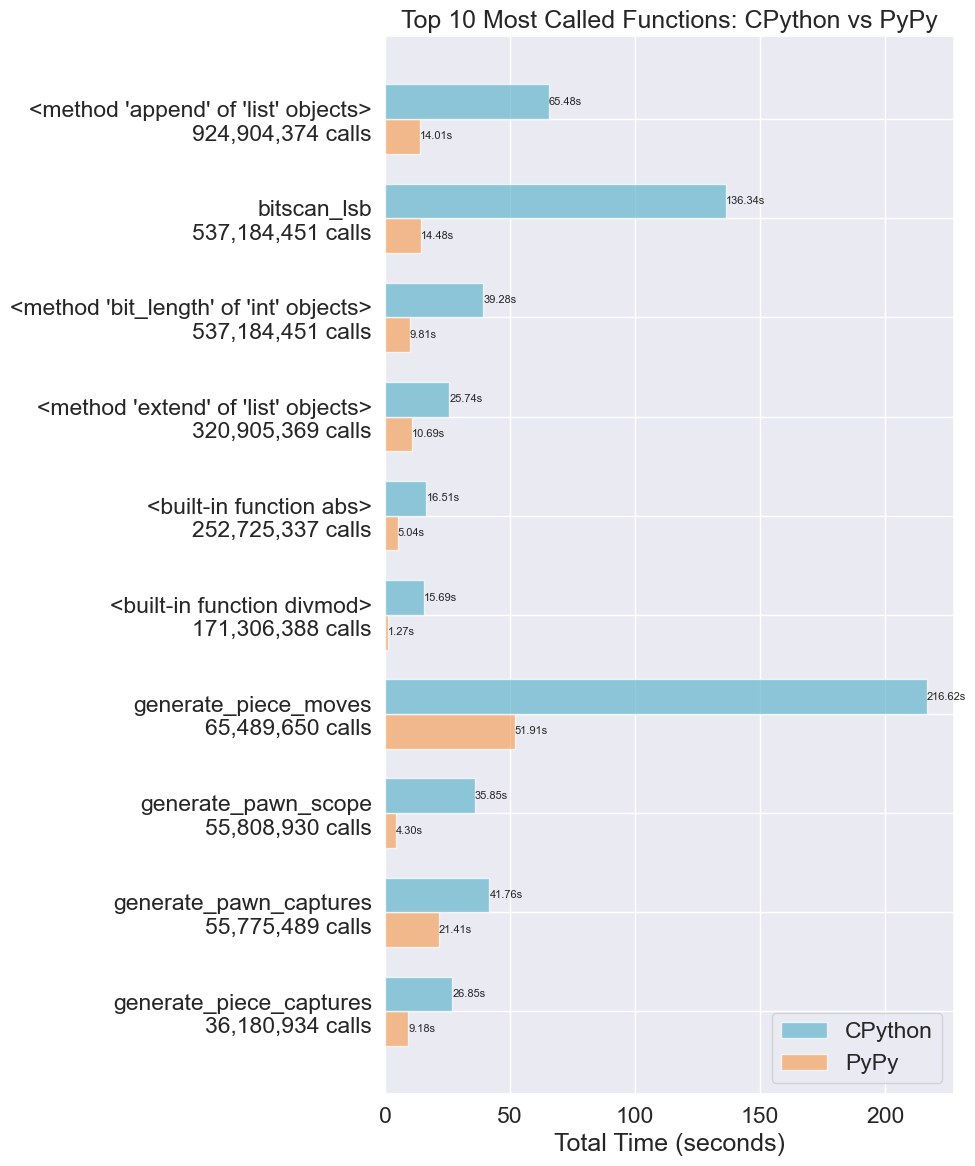

In [480]:
# Sort by total time in CPython and select top 10
top_10_called = df_pivot.sort_values('nc_CPython', ascending=False).head(10).iloc[::-1]

fig, ax = plt.subplots(figsize=(10, 12))

y = range(len(top_10_called))
height = 0.35

cpython_bars = ax.barh([i + height for i in y], top_10_called['tt_CPython'], height, label='CPython', color='c', alpha=0.7, zorder=20)
pypy_bars = ax.barh(y, top_10_called['tt_PyPy'], height, label='PyPy', color='sandybrown', alpha=0.7, zorder=10)

# Add time labels to bars
for bar in cpython_bars + pypy_bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2,
            f'{width:.2f}s',
            ha='left', va='center', fontsize=8, zorder=30)

ax.set_xlabel('Total Time (seconds)')
ax.set_title('Top 10 Most Called Functions: CPython vs PyPy')

# Create y-axis labels with function names and call counts
labels = [f"{row['name']}\n{int(row['nc_CPython']):,} calls" 
          for _, row in top_10_called.iterrows()]

ax.set_yticks([i + height/2 for i in y])
ax.set_yticklabels(labels)

ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

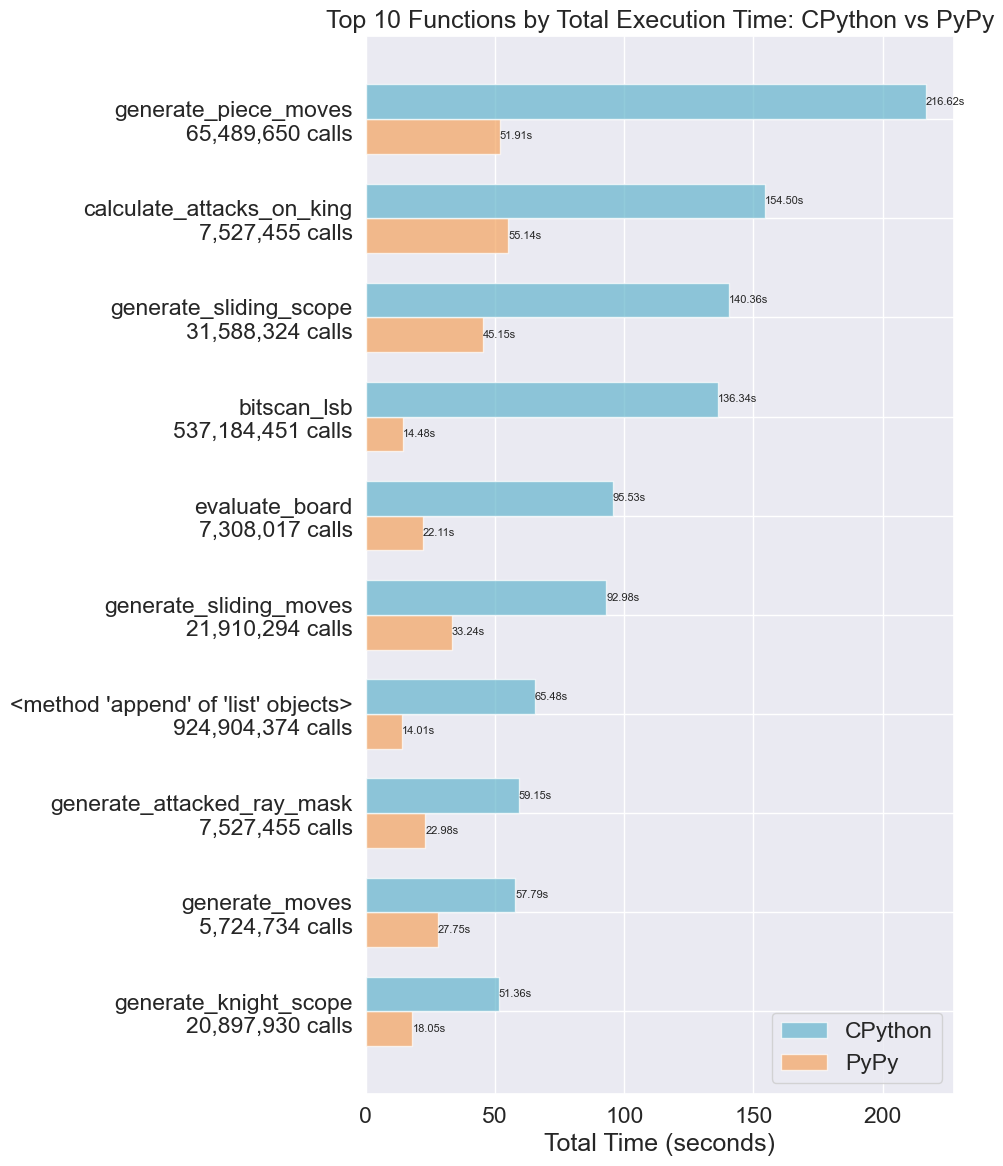

In [481]:
# Sort by total time in CPython and select top 10
top_10_time = df_pivot.sort_values('tt_CPython', ascending=False).head(10).iloc[::-1]

fig, ax = plt.subplots(figsize=(10, 12))

y = range(len(top_10_time))
height = 0.35

cpython_bars = ax.barh([i + height for i in y], top_10_time['tt_CPython'], height, label='CPython', color='c', alpha=0.7, zorder=20)
pypy_bars = ax.barh(y, top_10_time['tt_PyPy'], height, label='PyPy', color='sandybrown', alpha=0.7, zorder=10)

# Add time labels to bars
for bar in cpython_bars + pypy_bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2,
            f'{width:.2f}s',
            ha='left', va='center', fontsize=8, zorder=30)

ax.set_xlabel('Total Time (seconds)')
ax.set_title('Top 10 Functions by Total Execution Time: CPython vs PyPy')

# Create y-axis labels with function names and call counts
labels = [f"{row['name']}\n{int(row['nc_CPython']):,} calls" 
          for _, row in top_10_time.iterrows()]

ax.set_yticks([i + height/2 for i in y])
ax.set_yticklabels(labels)

ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

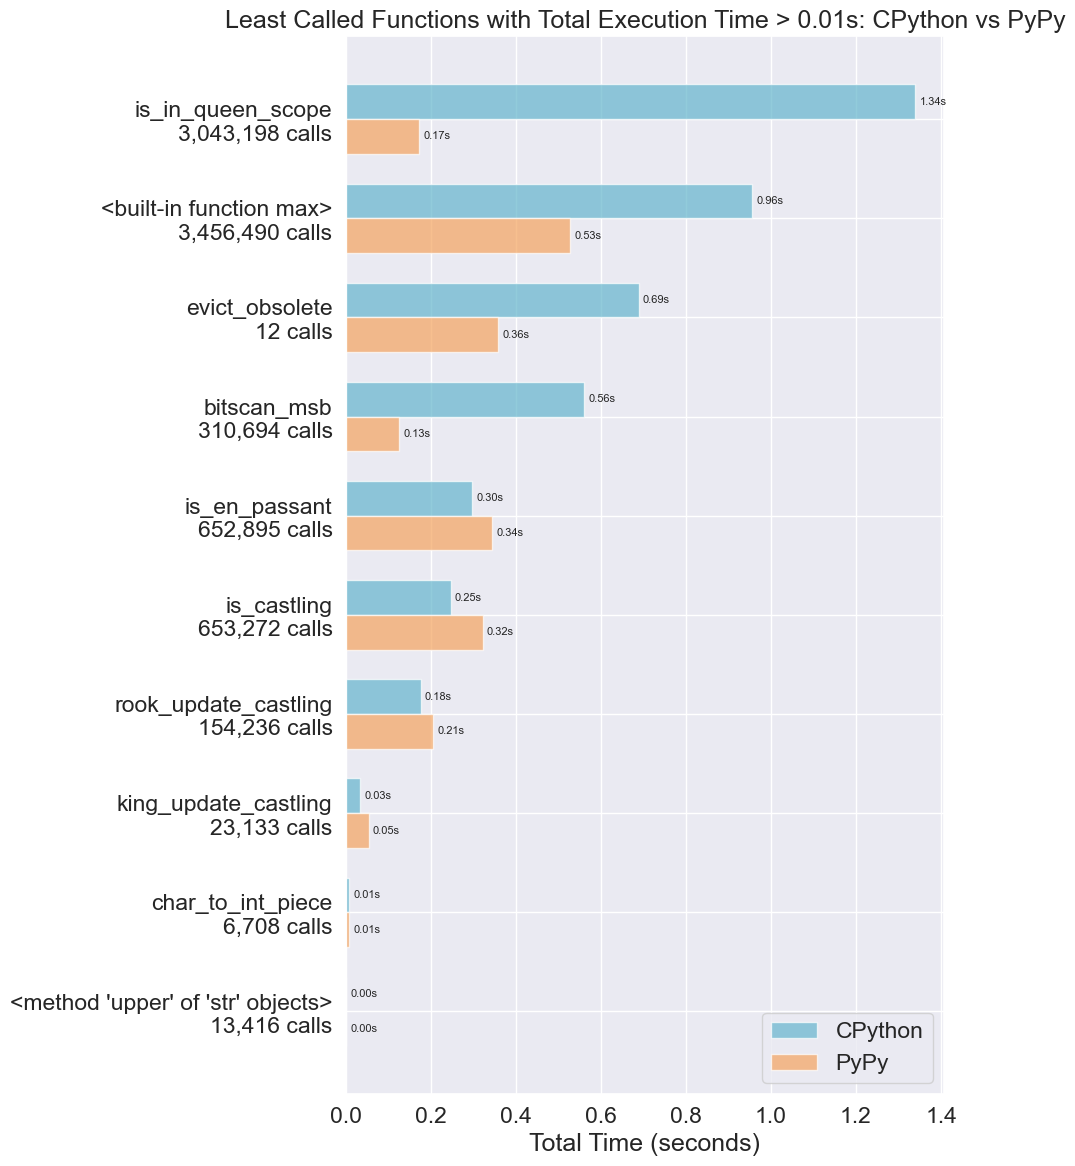

In [482]:
# Set Threshold for signficant functions
significant_time = df_pivot[(df_pivot['tt_CPython'] > 0.001) & (df_pivot['tt_PyPy'] > 0.001)]

# Sort by total time in CPython
significant_time = significant_time.sort_values('tt_CPython', ascending=True).head(10)

fig, ax = plt.subplots(figsize=(10, 12))

y = range(len(significant_time))
width = 0.35

cpython_bars = ax.barh([i + width for i in y], significant_time['tt_CPython'], width, label='CPython', color='c', alpha=0.7)
pypy_bars = ax.barh(y, significant_time['tt_PyPy'], width, label='PyPy', color='sandybrown', alpha=0.7)

# Add time labels to bars
def add_time_labels(bars):
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{width:.2f}s',
                ha='left', va='center', fontsize=8, zorder=30)

add_time_labels(cpython_bars)
add_time_labels(pypy_bars)

labels = [f"{row['name']}\n{int(row['nc_CPython']):,} calls" 
          for _, row in significant_time.iterrows()]

ax.set_xlabel('Total Time (seconds)')
ax.set_title('Least Called Functions with Total Execution Time > 0.01s: CPython vs PyPy')
ax.set_yticks([i + height/2 for i in y])
ax.set_yticklabels(labels, rotation=0, ha='right')

ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [483]:
# Set thresholds
MIN_CALLS = 0  # Minimum number of calls to include a function
MIN_RUNTIME = 0  # Minimum runtime in seconds to include a function

# Relative difference
df_pivot['rel_perf_diff'] = (df_pivot['tt_CPython'] - df_pivot['tt_PyPy']) / (df_pivot['tt_CPython'] + df_pivot['tt_PyPy'])

# Filter out insignificant functions
df_significant = df_pivot[
    (df_pivot['nc_CPython'] >= MIN_CALLS) & 
    (df_pivot['tt_CPython'] >= MIN_RUNTIME) &
    (df_pivot['tt_PyPy'] >= MIN_RUNTIME)
]

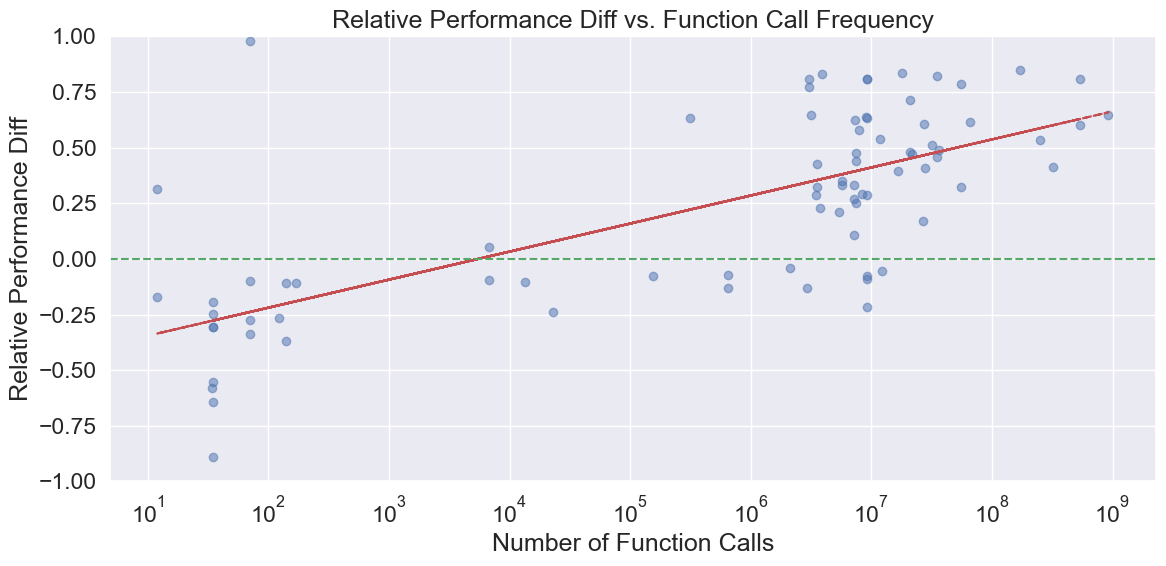

In [491]:
fig, ax = plt.subplots(figsize=(12, 6))
scatter = ax.semilogx(df_significant['nc_CPython'], df_significant['rel_perf_diff'], 'o', alpha=0.5)

# Linear fit line
z = np.polyfit(np.log10(df_significant['nc_CPython']), df_significant['rel_perf_diff'], 1)
p = np.poly1d(z)
ax.plot(df_significant['nc_CPython'], p(np.log10(df_significant['nc_CPython'])), "r--")

ax.set_ylim(-1, 1)
ax.set_xlabel('Number of Function Calls')
ax.set_ylabel('Relative Performance Diff')
ax.set_title(f'Relative Performance Diff vs. Function Call Frequency')

# Break even line
ax.axhline(y=0, color='g', linestyle='--')

# Set log scale for x-axis
ax.set_xscale('log')

plt.tight_layout()
plt.show()

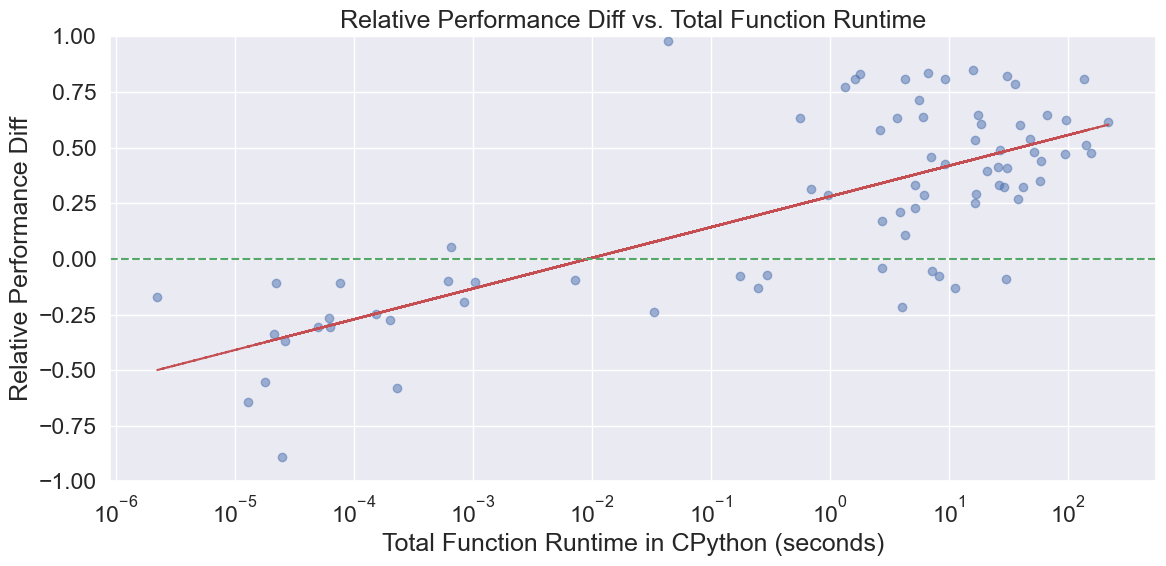

In [492]:
def format_seconds(x, pos):
    if x < 1:
        return f'{x*1e3:.1f}ms'
    else:
        return f'{x:.1f}s'

fig, ax = plt.subplots(figsize=(12, 6))
scatter = ax.semilogx(df_significant['tt_CPython'], df_significant['rel_perf_diff'], 'o', alpha=0.5)

# Linear fit line
z = np.polyfit(np.log10(df_significant['tt_CPython']), df_significant['rel_perf_diff'], 1)
p = np.poly1d(z)
ax.plot(df_significant['tt_CPython'], p(np.log10(df_significant['tt_CPython'])), "r--")

ax.set_ylim(-1, 1)
ax.set_xlabel('Total Function Runtime in CPython (seconds)')
ax.set_ylabel('Relative Performance Diff')
ax.set_title(f'Relative Performance Diff vs. Total Function Runtime')

# Break even line
ax.axhline(y=0, color='g', linestyle='--')

# Set log scale for x-axis
ax.set_xscale('log')

plt.tight_layout()
plt.show()

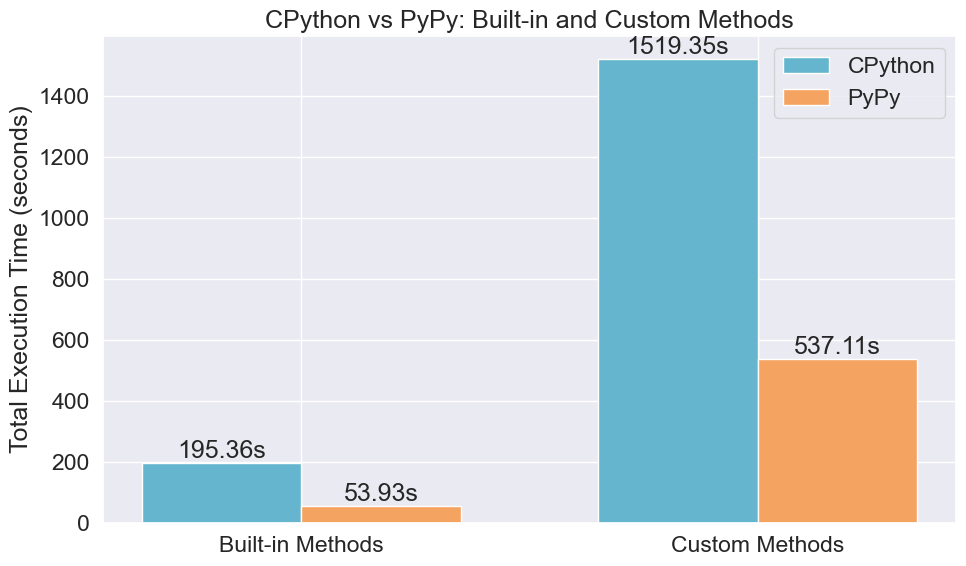

Number of built-in methods: 20
Number of custom methods: 59

Built-in methods:
Num Calls: 2283160379
CPython total time: 195.36s
PyPy total time: 53.93s
Speedup: 3.62x

Custom methods:
Num Calls: 1173733535
CPython total time: 1519.35s
PyPy total time: 537.11s
Speedup: 2.83x


In [489]:
def is_builtin(name):
    return '<' in name or name == '__init__'

# Separate built-in and custom methods
df_significant.loc[:, 'is_builtin'] = df_significant['name'].apply(is_builtin)
df_builtin = df_significant[df_significant['is_builtin']]
df_custom = df_significant[~df_significant['is_builtin']]

# Calculate total execution times
builtin_cpython = df_builtin['tt_CPython'].sum()
builtin_pypy = df_builtin['tt_PyPy'].sum()
custom_cpython = df_custom['tt_CPython'].sum()
custom_pypy = df_custom['tt_PyPy'].sum()

builtin_nc = df_builtin['nc_CPython'].sum()
custom_nc = df_custom['nc_CPython'].sum()

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(2)
width = 0.35

cpython_bars = ax.bar(x - width/2, [builtin_cpython, custom_cpython], width, label='CPython', color='c')
pypy_bars = ax.bar(x + width/2, [builtin_pypy, custom_pypy], width, label='PyPy', color='sandybrown')

ax.set_ylabel('Total Execution Time (seconds)')
ax.set_title('CPython vs PyPy: Built-in and Custom Methods')
ax.set_xticks(x)
ax.set_xticklabels(['Built-in Methods', 'Custom Methods'])
ax.legend()

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height,
                f'{height:.2f}s',
                ha='center', va='bottom')

add_labels(cpython_bars)
add_labels(pypy_bars)

plt.tight_layout()
plt.show()

# Print stats
print(f"Number of built-in methods: {len(df_builtin)}")
print(f"Number of custom methods: {len(df_custom)}")
print(f"\nBuilt-in methods:")
print(f"Num Calls: {int(builtin_nc)}")
print(f"CPython total time: {builtin_cpython:.2f}s")
print(f"PyPy total time: {builtin_pypy:.2f}s")
print(f"Speedup: {builtin_cpython/builtin_pypy:.2f}x")
print(f"\nCustom methods:")
print(f"Num Calls: {int(custom_nc)}")
print(f"CPython total time: {custom_cpython:.2f}s")
print(f"PyPy total time: {custom_pypy:.2f}s")
print(f"Speedup: {custom_cpython/custom_pypy:.2f}x")